         
           Neg  Pos
  Placebo 5056  154
  Vaccine 5194   64

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Wed Jul  7 16:10:29 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 10468
   Unobserved stochastic nodes: 2
   Total graph size: 20945
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 15000
-------------------------------------------------| 15000
************************************************** 100%
. . . . Updating 0
. Deleting model
All chains have finished
Note: the model did not requ

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.02499880,0.02948695,0.0340862,0.02954318,0.002328519,NA,1.164259e-05,0.5,40000,0.002045016,0.9999838
theta[2],0.00966311,0.01243560,0.0155313,0.01250547,0.001516709,NA,7.551991e-06,0.5,40335,-0.004148353,1.0000207
theta[3],45.16870000,57.81700000,69.2225000,57.40302815,6.206273499,NA,3.147677e-02,0.5,38876,-0.003712590,1.0000209


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 3 variables....



JAGS model summary statistics from 60000 samples (chains = 4; adapt+burnin = 5000):
                                                                               
           Lower95   Median  Upper95     Mean        SD Mode      MCerr MC%ofSD
theta[1]  0.025118 0.029489 0.034185 0.029549 0.0023219   -- 9.4463e-06     0.4
theta[2] 0.0096337 0.012442 0.015522 0.012506 0.0015173   -- 6.1594e-06     0.4
theta[3]    45.169    57.83   69.168   57.411    6.1988   --   0.025307     0.4
                                
         SSeff      AC.10   psrf
theta[1] 60417   0.002045      1
theta[2] 60684 -0.0041484      1
theta[3] 60000 -0.0037126 1.0001

Total time taken: 24.7 seconds


,Parameter,MAP,CI,CI_low,CI_high,pd
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Posterior,58.42576,0.95,45.16883,69.16821,1


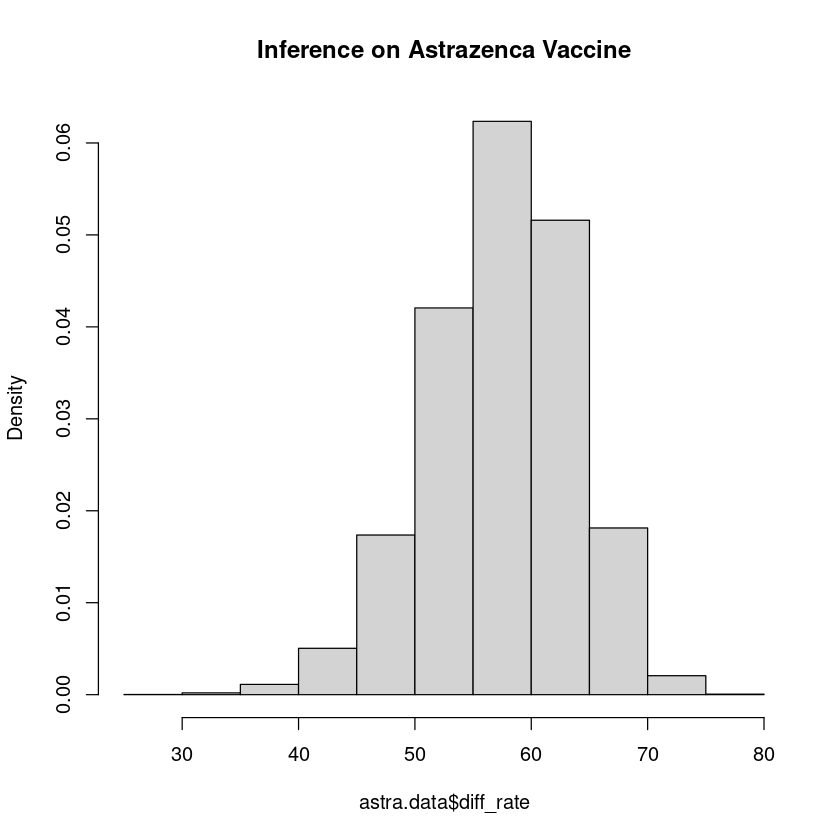

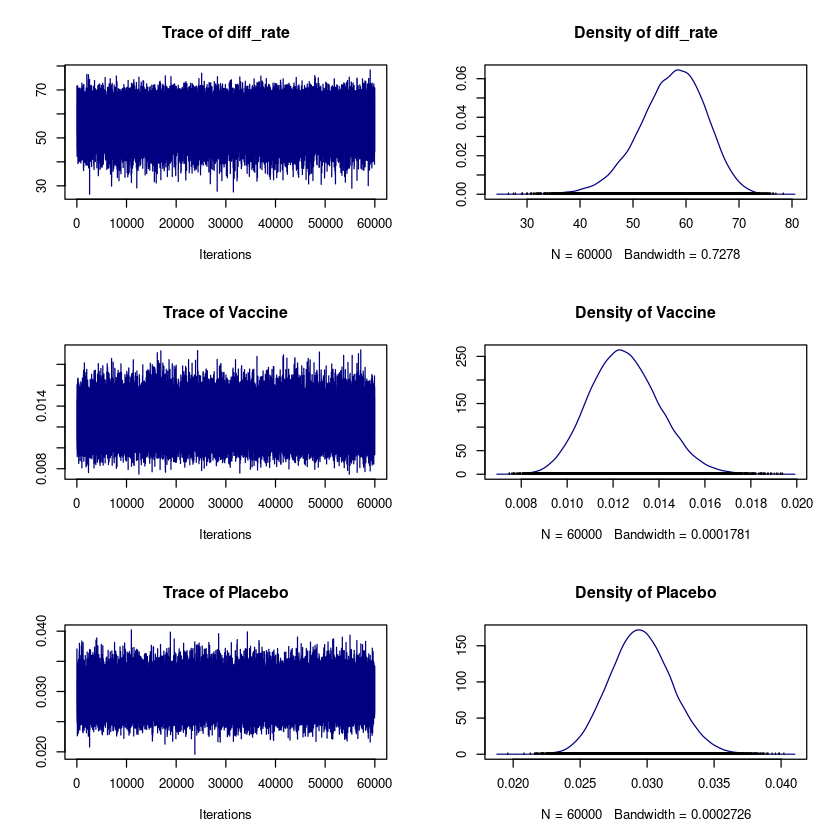

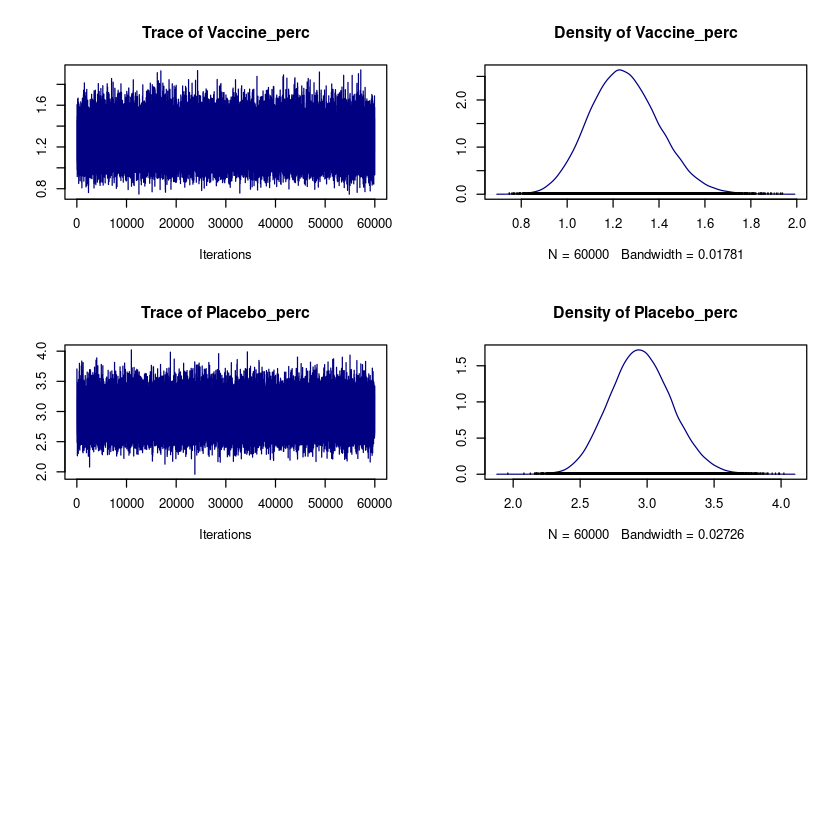

In [34]:
library(rjags)
library(runjags)
library(R2jags)
library(tidybayes)
library(dplyr)
library(coda)
library(rstanarm)
library(plotrix)
library(dupiR)

tot_vaccine <- 5258
tot_placebo <- 5210
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 64
pos_placebo <- 154
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
astra.tb <- tibble::tibble(tested = tested, patient=patient)
table(astra.tb[[2]], astra.tb[[1]])

dataList = list(
    tested = ifelse(astra.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(astra.tb$patient)),
    Ntot = nrow(astra.tb) ,
    Nclass = nlevels(factor(astra.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(3 , 100)    
    }
  theta[3] = (theta[1]-theta[2])/theta[1] * 100
  }"
writeLines(modelString , con="jags_Astra_model.txt")

astra_chains <- run.jags(modelString ,
                          sample = 15000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(astra_chains)
add.summary(astra_chains)

astra_res    <- tidybayes::tidy_draws(astra_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

astra.mcmc <- as.mcmc(astra_res)
astra.data <- as.data.frame(astra.mcmc)

hist(astra.data$diff_rate,freq=FALSE,main='Inference on Astrazenca Vaccine')

bayestestR::describe_posterior(astra.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")

plot(astra.mcmc[,c('diff_rate','Vaccine','Placebo','Vaccine_perc','Placebo_perc')],col='navy')

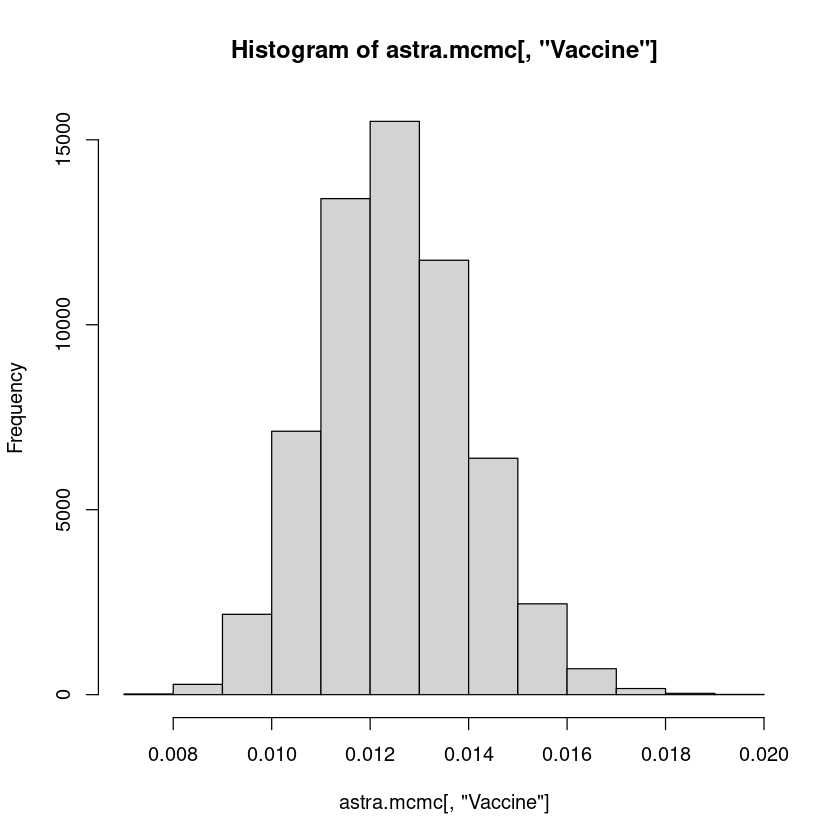

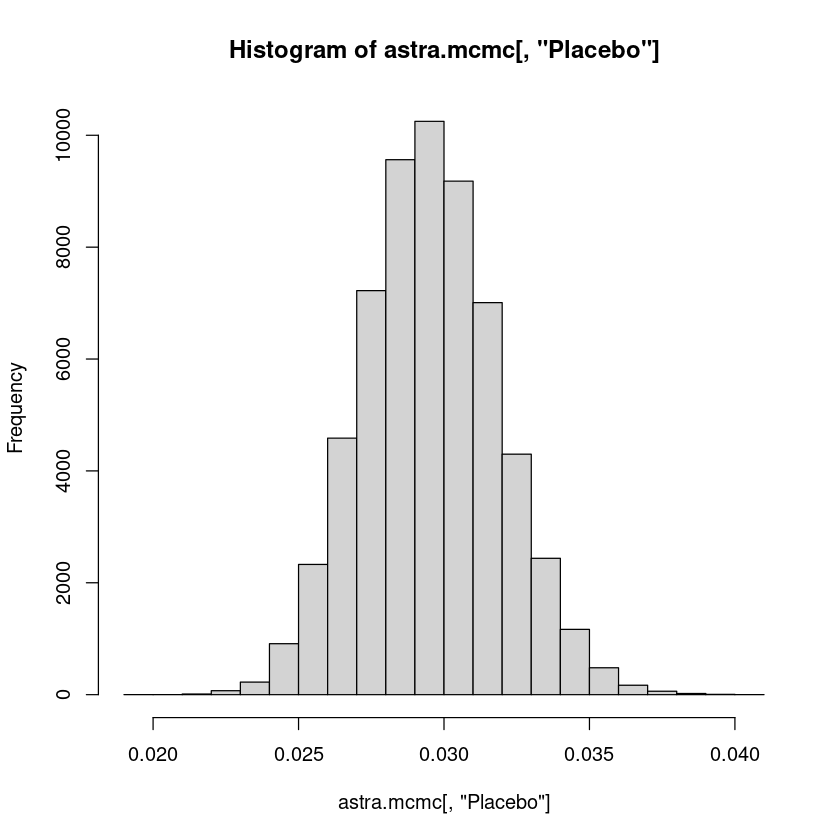

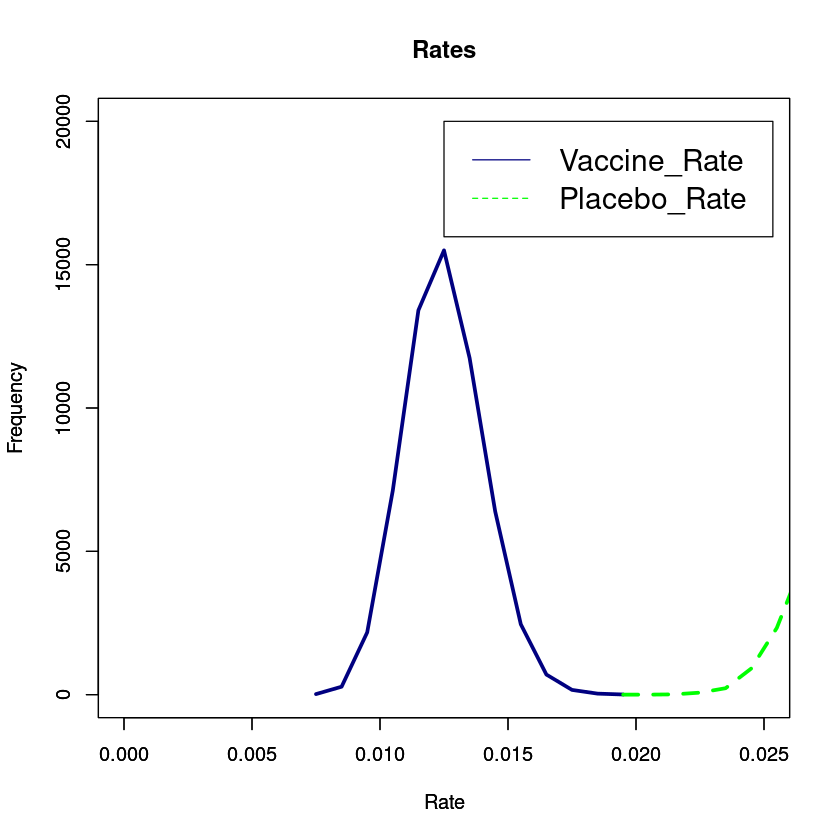

In [35]:
h1 <- hist(astra.mcmc[,'Vaccine'])
h2 <- hist(astra.mcmc[,'Placebo'])

#pdf(file='Astrazeneca(Rate)')
plot(h1$mids,h1$counts,type='l',lwd=3,col='navy',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),main='Rates')
par(new=TRUE)
plot(h2$mids,h2$counts,type='l',lwd=3,col='green',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),lty=2)
legend(0.0125,20000,c('Vaccine_Rate','Placebo_Rate'), col=c('navy','green'),lty=1:2,cex=1.5)
#dev.off()

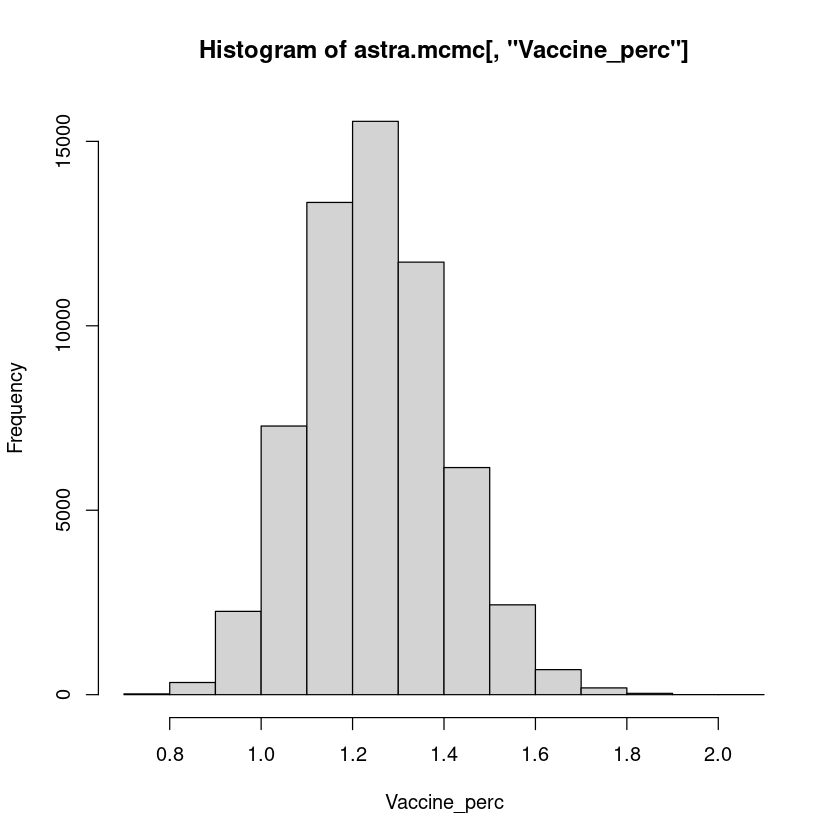

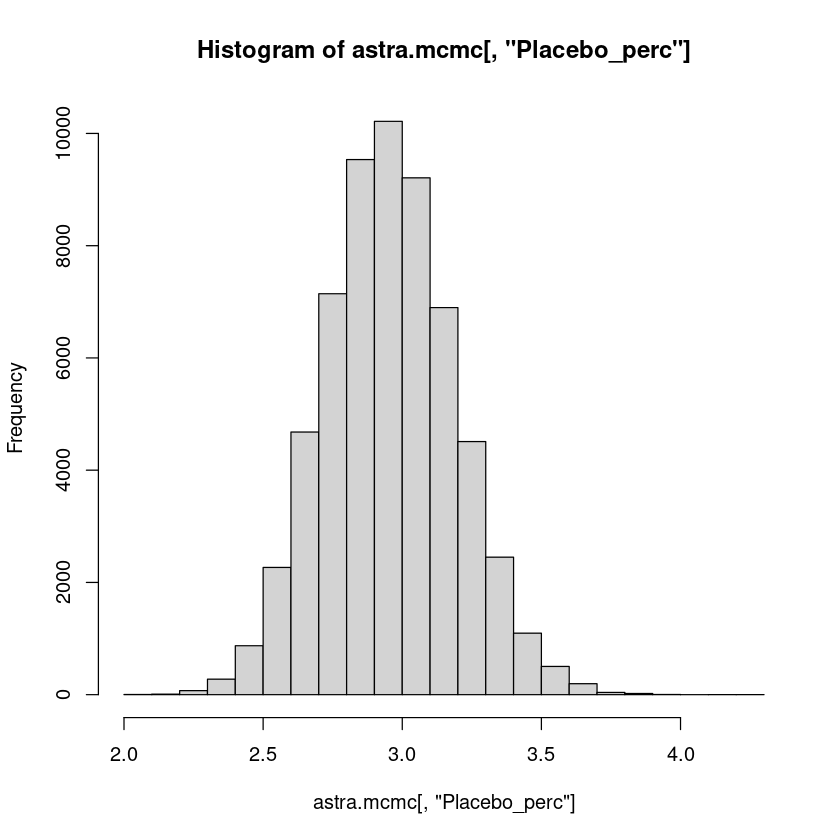

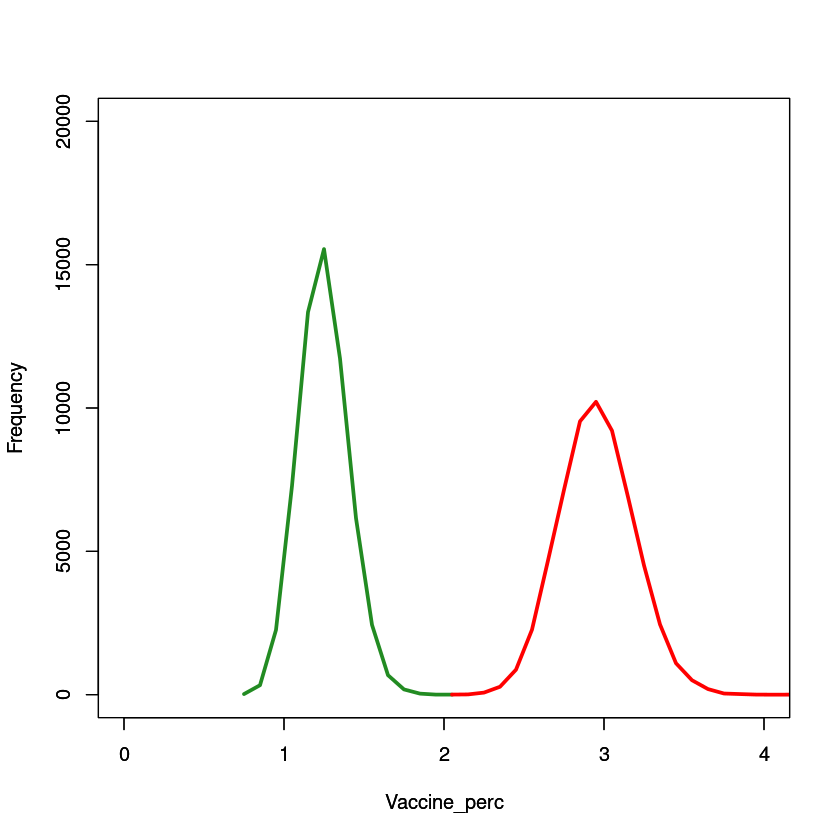

In [8]:
h1 <- hist(astra.mcmc[,'Vaccine_perc'],xlab='Vaccine_perc')
h2 <- hist(astra.mcmc[,'Placebo_perc'])
plot(h1$mids,h1$counts,type='l',lwd=3,col='forestgreen',
     xlab='Vaccine_perc',ylab='Frequency',xlim=range(0,4),ylim=range(0,20000))
par(new=TRUE)
plot(h2$mids,h2$counts,type='l',lwd=3,col='red',
     xlab='Vaccine_perc',ylab='Frequency',xlim=range(0,4),ylim=range(0,20000))

In [1]:
library(rjags)
library(runjags)
library(R2jags)
library(tidybayes)
library(dplyr)
library(coda)
library(rstanarm)
library(plotrix)
library(dupiR)

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp

This is rstanarm version 2.21.1

- See https://mc-stan.org/rstanarm/articles/priors for changes to default priors!

- Default priors may change, so it's safest to specify priors, even if equivalent to the defaults.

- For execution on a local, multicore CPU with excess RAM we recommend calling

  options(mc.cores = parallel::detectCores())



In [3]:
### overall


tot_vaccine <- 17411
tot_placebo <- 17511
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 8
pos_placebo <- 162
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
vaccine.tb <- tibble::tibble(tested = tested, patient=patient)
table(vaccine.tb[[2]], vaccine.tb[[1]])

dataList = list(
    tested = ifelse(vaccine.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(vaccine.tb$patient)),
    Ntot = nrow(vaccine.tb) ,
    Nclass = nlevels(factor(vaccine.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(0.010101 , 1)    
    }
  }"
writeLines(modelString , con="jags_Vaccine_model.txt")

vaccine_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(vaccine_chains)
add.summary(vaccine_chains)


### Efficacy

vaccine_res    <- tidybayes::tidy_draws(vaccine_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Efficacy = 100 * (1 - ((Vaccine/(Vaccine + Placebo))/(1 - (Vaccine/(Vaccine + Placebo))))),
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

vaccine.mcmc <- as.mcmc(vaccine_res)
vaccine.data <- as.data.frame(vaccine.mcmc)
tb= bayestestR::describe_posterior(vaccine.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")


bayestestR::describe_posterior(vaccine.data$Efficacy,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")

#pdf(file='Pfizer(overall)')
#hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Pfizer (overall) Vaccine',xlab='Efficacy')
#abline(v=tb$CI_low,lty=2)
#abline(v=tb$CI_high,lty=2)
#dev.off()

         
            Neg   Pos
  Placebo 17349   162
  Vaccine 17403     8

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Fri Jul  9 06:29:38 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 34922
   Unobserved stochastic nodes: 2
   Total graph size: 69850
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.00786924,0.00923331,0.010705600,0.0092524696,0.0007241319,NA,3.589231e-06,0.5,40704,0.002461103,1.000052
theta[2],0.00017734,0.00044186,0.000790836,0.0004607171,0.0001626479,NA,8.132395e-07,0.5,40000,-0.003266227,1.000068


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                               
            Lower95     Median    Upper95       Mean         SD Mode      MCerr
theta[1]  0.0078771  0.0092315   0.010705  0.0092522 0.00072314   -- 2.5476e-06
theta[2] 0.00017531 0.00044129 0.00079067 0.00046039 0.00016284   -- 5.7574e-07
                                      
         MC%ofSD SSeff      AC.10 psrf
theta[1]     0.4 80568  0.0024611    1
theta[2]     0.4 80000 -0.0032662    1

Total time taken: 1.7 minutes


,Parameter,MAP,CI,CI_low,CI_high,pd
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Posterior,95.7488,0.95,91.39569,98.22935,1


In [12]:
str(vaccine_res)

tibble [80,000 × 5] (S3: tbl_df/tbl/data.frame)
 $ Placebo     : num [1:80000] 0.0098 0.01041 0.00925 0.00879 0.00889 ...
 $ Vaccine     : num [1:80000] 0.000411 0.000429 0.000336 0.000377 0.000546 ...
 $ diff_rate   : num [1:80000] 95.8 95.9 96.4 95.7 93.9 ...
 $ Placebo_perc: num [1:80000] 0.98 1.041 0.925 0.879 0.889 ...
 $ Vaccine_perc: num [1:80000] 0.0411 0.0429 0.0336 0.0377 0.0546 ...


In [13]:
str(vaccine.mcmc)

 'mcmc' num [1:80000, 1:5] 0.0098 0.01041 0.00925 0.00879 0.00889 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:5] "Placebo" "Vaccine" "diff_rate" "Placebo_perc" ...
 - attr(*, "mcpar")= num [1:3] 1 80000 1


In [14]:
str(vaccine.data)

'data.frame':	80000 obs. of  5 variables:
 $ Placebo     : num  0.0098 0.01041 0.00925 0.00879 0.00889 ...
 $ Vaccine     : num  0.000411 0.000429 0.000336 0.000377 0.000546 ...
 $ diff_rate   : num  95.8 95.9 96.4 95.7 93.9 ...
 $ Placebo_perc: num  0.98 1.041 0.925 0.879 0.889 ...
 $ Vaccine_perc: num  0.0411 0.0429 0.0336 0.0377 0.0546 ...


In [17]:
?sort

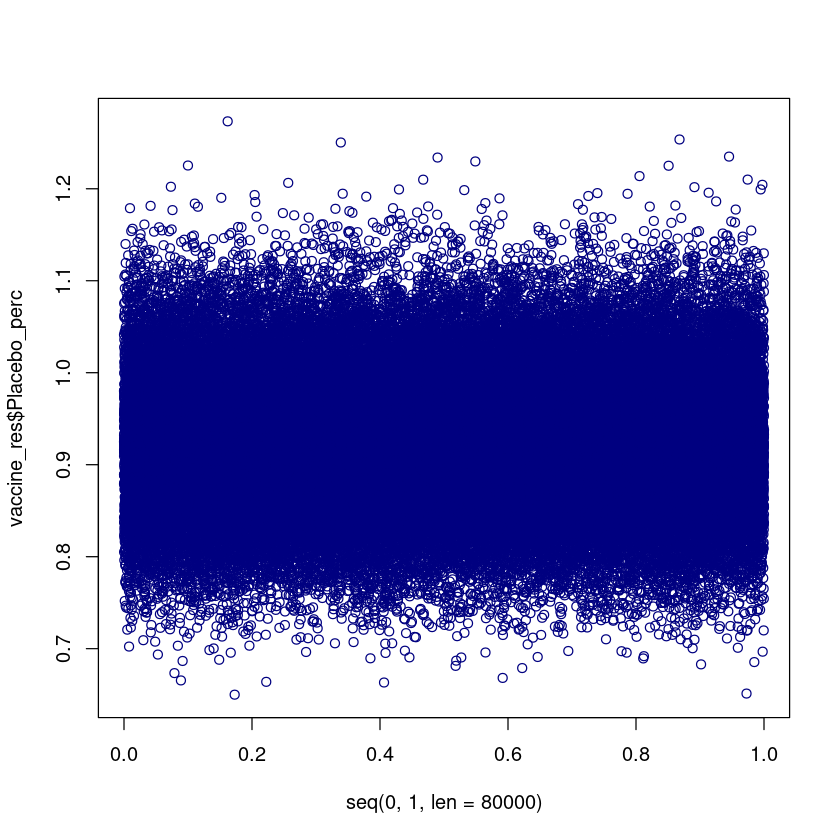

In [18]:
plot(seq(0,1,len=80000),vaccine_res$Placebo_perc,col='navy')


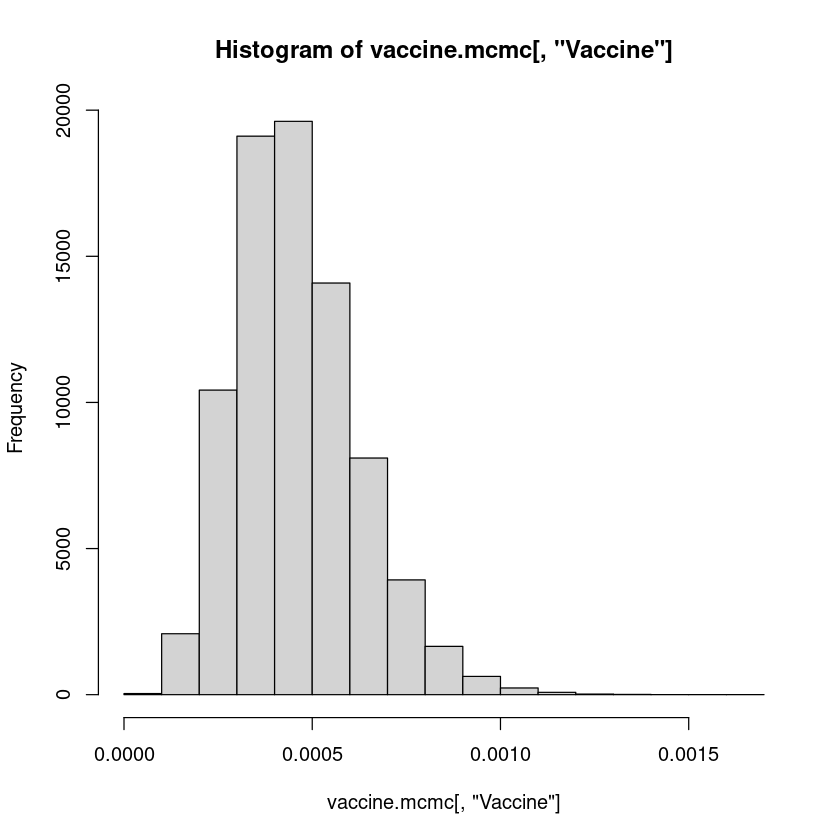

png 
  2

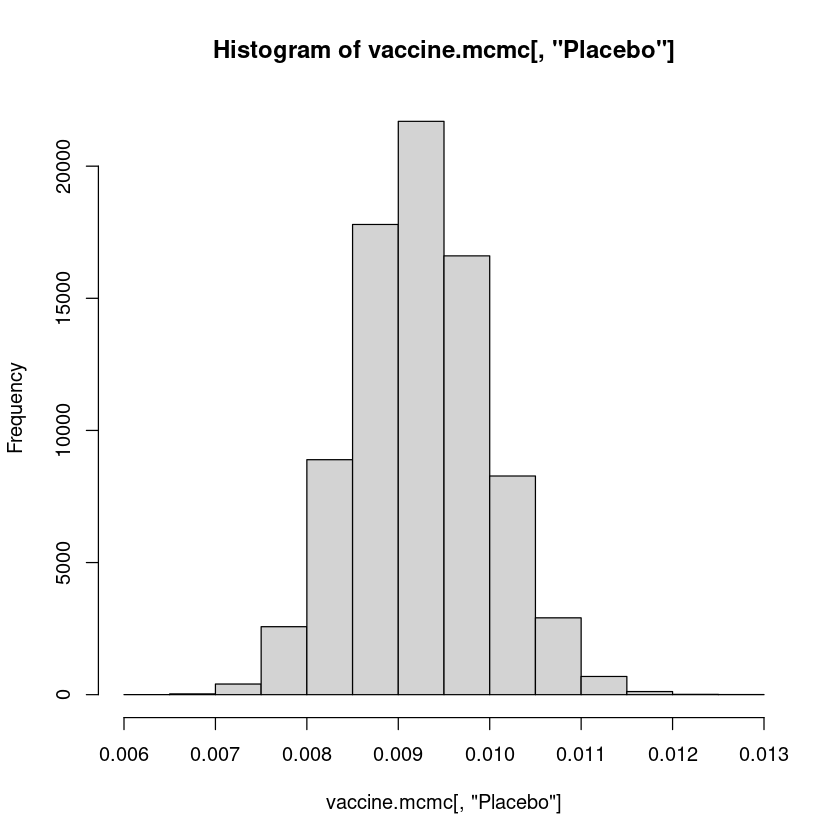

In [26]:
h1 <- hist(vaccine.mcmc[,'Vaccine'])
h2 <- hist(vaccine.mcmc[,'Placebo'])

pdf(file='Pfizer(Rate)')
plot(h1$mids,h1$counts,type='l',lwd=3,col='navy',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000))
par(new=TRUE)
plot(h2$mids,h2$counts,type='l',lwd=3,col='green',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),lty=2)
legend(0.0125,18000,c('Vaccine_Rate','Placebo_Rate'), col=c('navy','green'),lty=1:2,cex=1.5)
dev.off()

         
            Neg   Pos
  Placebo 13888   185
  Vaccine 14123    11

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Wed Jul  7 16:04:41 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 28207
   Unobserved stochastic nodes: 2
   Total graph size: 56420
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.011278300,0.01312780,0.01502370,0.0131405578,0.0009568157,NA,4.784079e-06,0.5,40000,-0.0014611732,1.000014
theta[2],0.000361097,0.00075317,0.00124526,0.0007783468,0.0002334099,NA,1.166118e-06,0.5,40064,0.0002419522,1.000014


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                             
            Lower95     Median   Upper95       Mean        SD Mode      MCerr
theta[1]   0.011288   0.013122  0.015043    0.01314 0.0009588   -- 3.4099e-06
theta[2] 0.00035584 0.00075392 0.0012499 0.00077835 0.0002349   -- 8.2596e-07
                                      
         MC%ofSD SSeff      AC.10 psrf
theta[1]     0.4 79063 -0.0014612    1
theta[2]     0.4 80882 0.00024195    1

Total time taken: 1.5 minutes


png 
  2

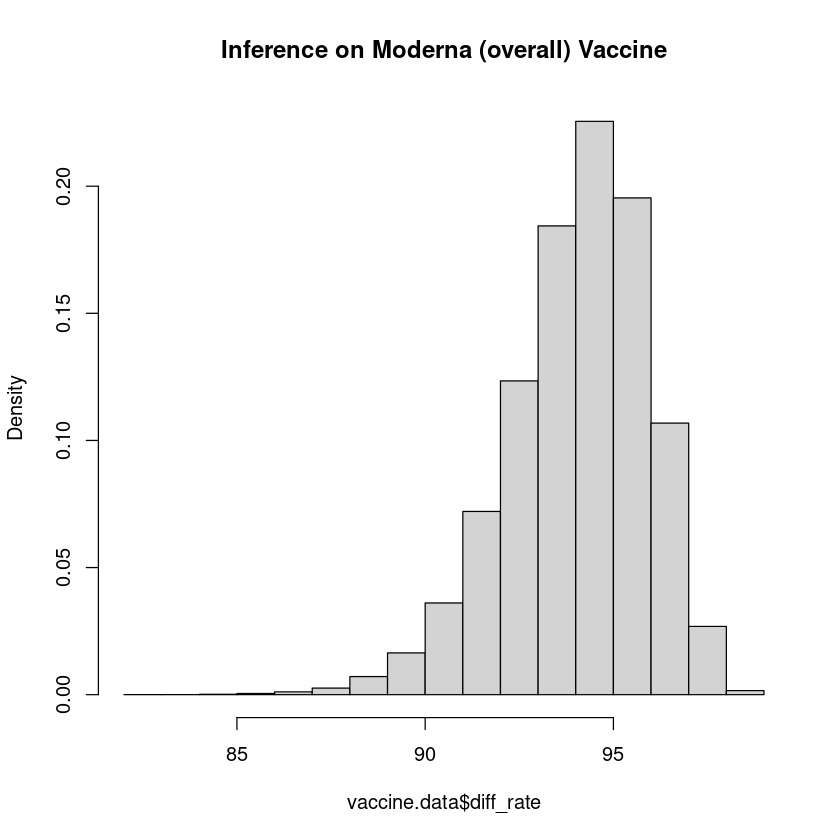

In [27]:
### overall


tot_vaccine <- 14134
tot_placebo <- 14073
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 11
pos_placebo <- 185
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
vaccine.tb <- tibble::tibble(tested = tested, patient=patient)
table(vaccine.tb[[2]], vaccine.tb[[1]])

dataList = list(
    tested = ifelse(vaccine.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(vaccine.tb$patient)),
    Ntot = nrow(vaccine.tb) ,
    Nclass = nlevels(factor(vaccine.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(0.010101 , 1)    
    }
  }"
writeLines(modelString , con="jags_Vaccine_model.txt")

vaccine_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(vaccine_chains)
add.summary(vaccine_chains)


### Efficacy

vaccine_res    <- tidybayes::tidy_draws(vaccine_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

vaccine.mcmc <- as.mcmc(vaccine_res)
vaccine.data <- as.data.frame(vaccine.mcmc)

hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Moderna (overall) Vaccine')

tb = bayestestR::describe_posterior(vaccine.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")

pdf(file='Moderna(overall)')
hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Moderna (overall) Vaccine',xlab='Efficacy')
abline(v=tb$CI_low,lty=2)
abline(v=tb$CI_high,lty=2)
dev.off()

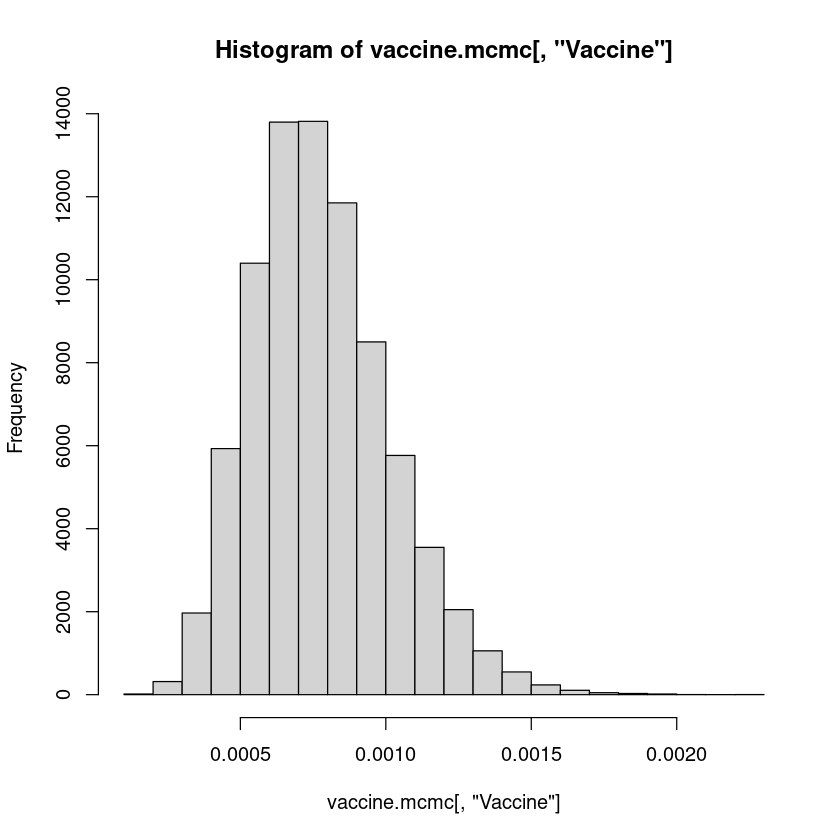

png 
  2

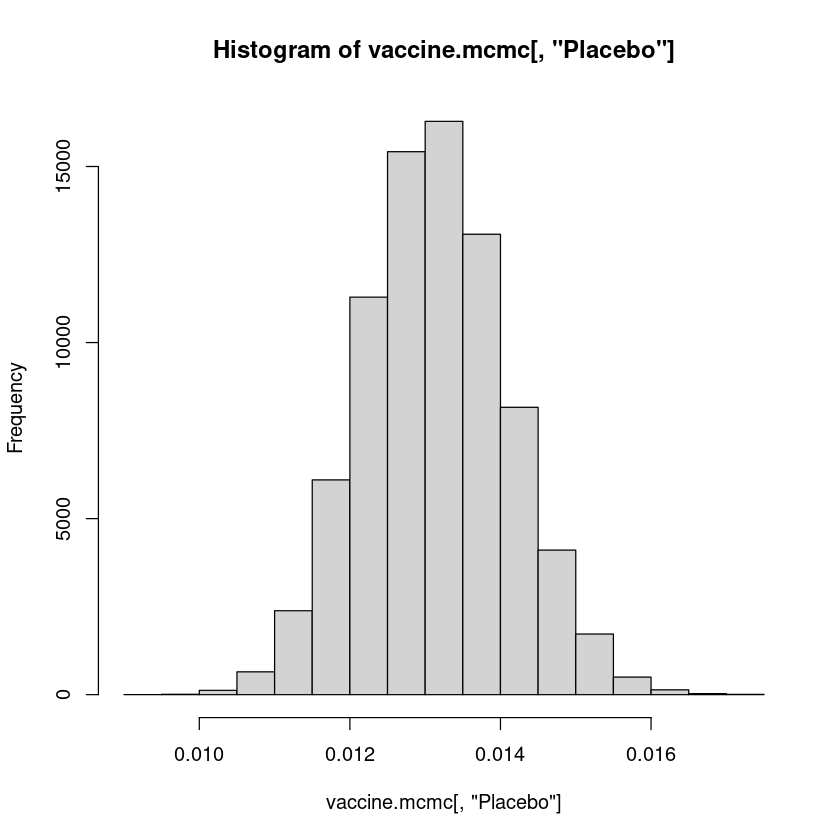

In [30]:
h1 <- hist(vaccine.mcmc[,'Vaccine'])
h2 <- hist(vaccine.mcmc[,'Placebo'])

pdf(file='Moderna(Rate)')
plot(h1$mids,h1$counts,type='l',lwd=3,col='navy',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),main='Rates')
par(new=TRUE)
plot(h2$mids,h2$counts,type='l',lwd=3,col='green',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),lty=2)
legend(0.0125,20000,c('Vaccine_Rate','Placebo_Rate'), col=c('navy','green'),lty=1:2,cex=1.5)
dev.off()

         
            Neg   Pos
  Placebo 19343   348
  Vaccine 19514   116

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Wed Jul  7 16:07:58 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 39321
   Unobserved stochastic nodes: 2
   Total graph size: 78648
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.01591690,0.01765380,0.01957930,0.017676079,0.0009341107,NA,4.689757e-06,0.5,39673,-0.0008538241,1.000055
theta[2],0.00482716,0.00589317,0.00696125,0.005907813,0.0005480362,NA,2.731304e-06,0.5,40260,-0.0015816095,1.000115


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                           
           Lower95    Median   Upper95      Mean         SD Mode      MCerr
theta[1]  0.015862  0.017656  0.019519  0.017676 0.00093386   -- 3.2913e-06
theta[2] 0.0048246 0.0058963 0.0069673 0.0059115 0.00054953   -- 1.9361e-06
                                       
         MC%ofSD SSeff       AC.10 psrf
theta[1]     0.4 80506 -0.00085382    1
theta[2]     0.4 80558  -0.0015816    1

Total time taken: 2 minutes


png 
  2

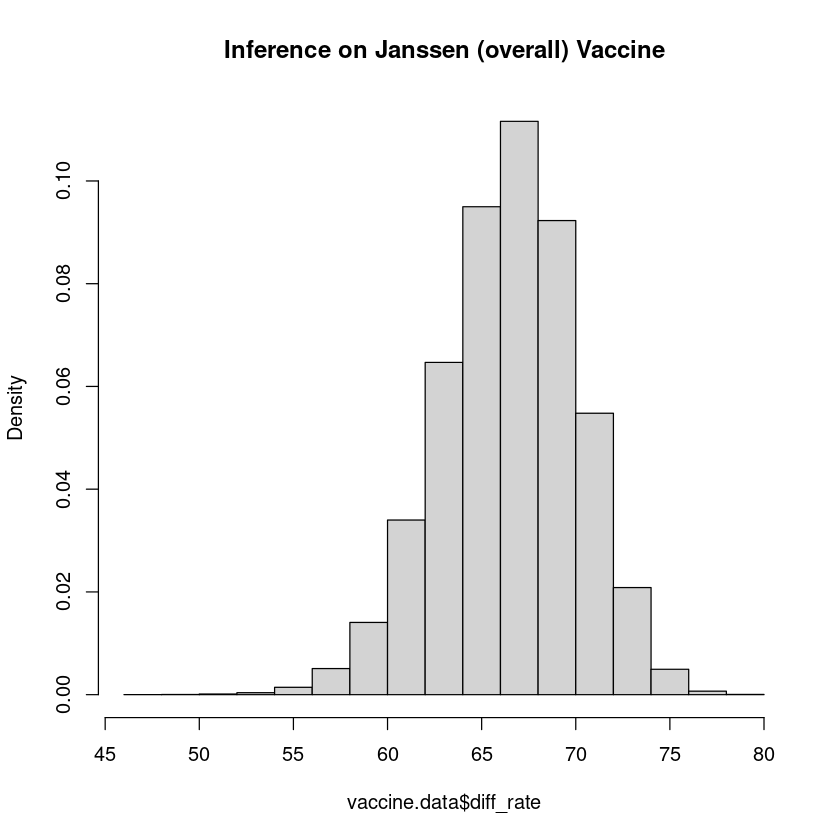

In [31]:
### overall


tot_vaccine <- 19630
tot_placebo <- 19691
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 116
pos_placebo <- 348
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
vaccine.tb <- tibble::tibble(tested = tested, patient=patient)
table(vaccine.tb[[2]], vaccine.tb[[1]])

dataList = list(
    tested = ifelse(vaccine.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(vaccine.tb$patient)),
    Ntot = nrow(vaccine.tb) ,
    Nclass = nlevels(factor(vaccine.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(0.010101 , 1)    
    }
  }"
writeLines(modelString , con="jags_Vaccine_model.txt")

vaccine_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(vaccine_chains)
add.summary(vaccine_chains)


### Efficacy

vaccine_res    <- tidybayes::tidy_draws(vaccine_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

vaccine.mcmc <- as.mcmc(vaccine_res)
vaccine.data <- as.data.frame(vaccine.mcmc)

hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Janssen (overall) Vaccine')

tb = bayestestR::describe_posterior(vaccine.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")


pdf(file='Janssen(overall)')
hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Janssen (overall) Vaccine',xlab='Efficacy')
abline(v=tb$CI_low,lty=2)
abline(v=tb$CI_high,lty=2)
dev.off()

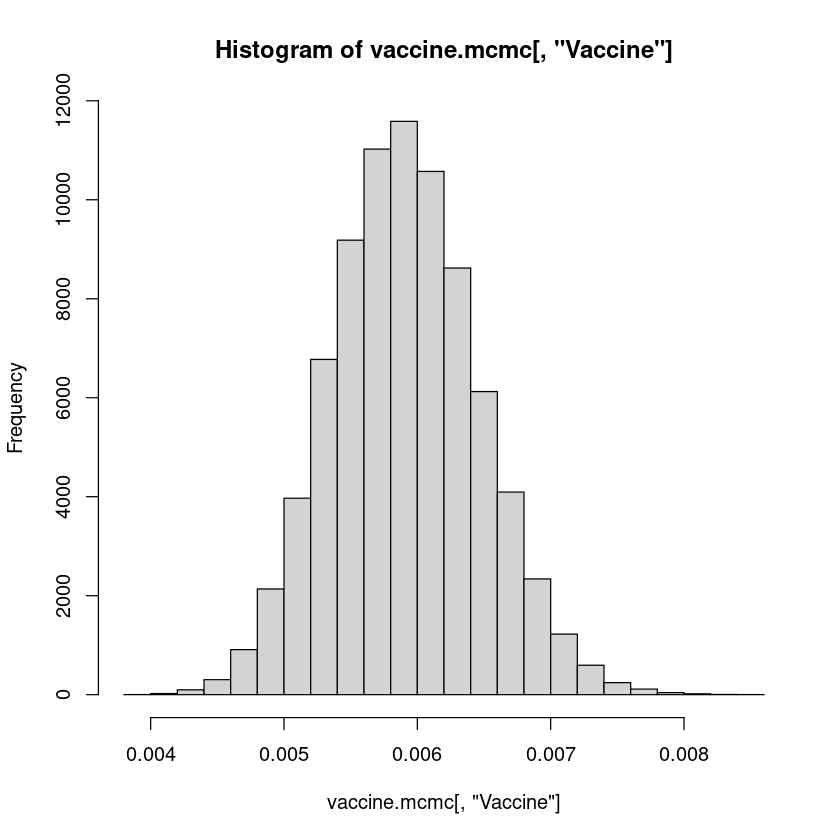

png 
  2

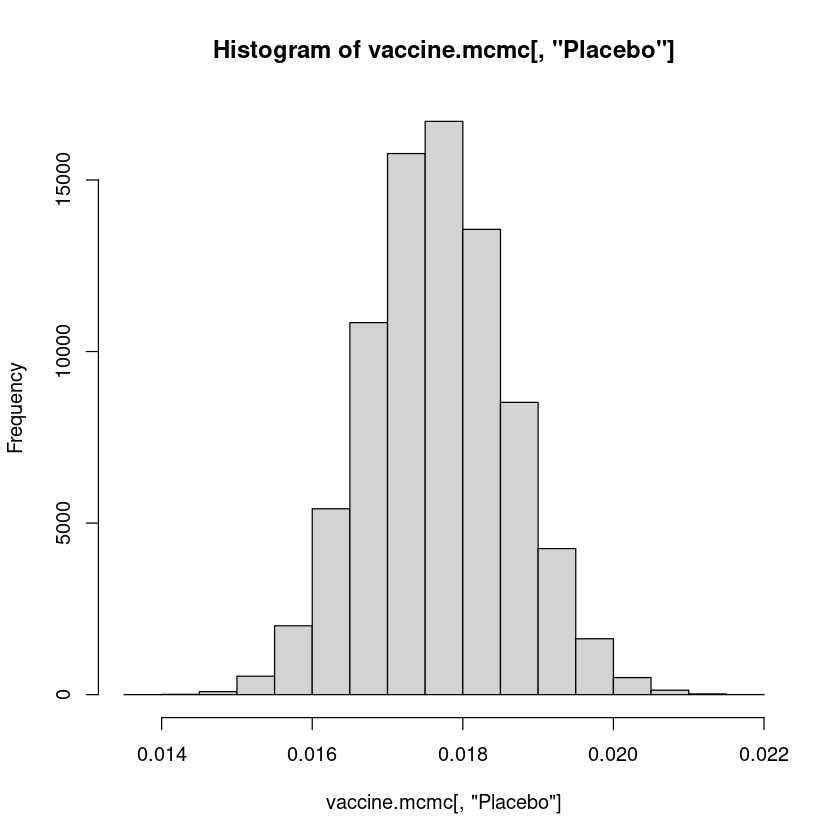

In [33]:
h1 <- hist(vaccine.mcmc[,'Vaccine'])
h2 <- hist(vaccine.mcmc[,'Placebo'])

pdf(file='Janssen(Rate)')
plot(h1$mids,h1$counts,type='l',lwd=3,col='navy',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),main='Rates')
par(new=TRUE)
plot(h2$mids,h2$counts,type='l',lwd=3,col='green',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),lty=2)
legend(0.0125,20000,c('Vaccine_Rate','Placebo_Rate'), col=c('navy','green'),lty=1:2,cex=1.5)
dev.off()